In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [5]:
from astropy.io import fits

In [6]:
kboltz=1.3806503e-23 #MKS
clight=299792458.0 #MKS
hplanck=6.626068e-34 #MKS
TCMB = 2.72548 #Kelvin
d2r = np.pi / 180.

In [7]:
from __future__ import unicode_literals

figsize(8,6)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [8]:
rc = 107.2
dc = 5.2

In [9]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [10]:
def calculate_sflux_gal(bank='A', session='5', pixbeam=1., smth=None, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='icrs', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    rc = 107.2
    dc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * (beam / 60. * d2r) **2
    pixelarea = pixbeam**2
    units = 1. / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= (45./60.)
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0

    annulus = (radius >= (60./60.) ) & (radius <= (90./60.))
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0

    sigma = beam / pixbeam / (2. * np.sqrt(2. * np.log(2)))
    signal = gaussian_filter(signal, sigma)
    shits = gaussian_filter(hits, sigma)
    mask = shits < 1
    
    rabinsc = (rabins[1:] + rabins[:-1]) / 2.
    decbinsc = (decbins[1:] + decbins[:-1]) / 2.
    if removeplane:
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
     
    if smth is not None:
        sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
        signal = gaussian_filter(signal, sigma, mode='mirror')
        shits = gaussian_filter(hits, sigma)
        #mask = hits < 1
        
    signal -= np.nanmedian(signal[outerregion])
    signal[mask] = np.nan
    shits[mask] = np.nan
    return signal, rabinsc, decbinsc, hits, innerregion, outerregion

In [11]:
#40' smoothing, 45' aperture, 60-90 annulus

In [12]:
signal, rabins, decbins, hits, inner, outer = calculate_sflux_gal('A', smth=39.9)

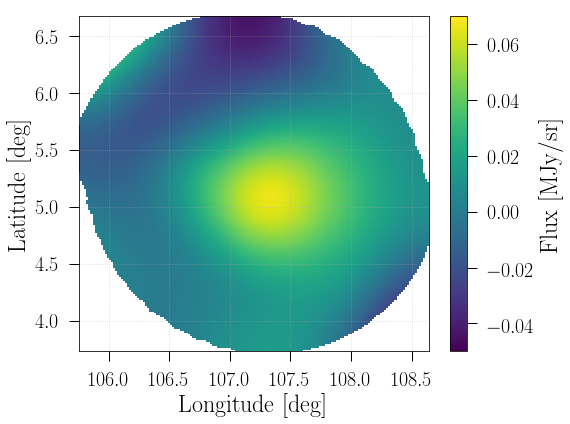

In [14]:
figure()
pc = pcolormesh(rabins, decbins, signal*1e-6, rasterized=True)
clim(-0.05, 0.07)
cb = colorbar()
cb.set_label('$\mathrm{Flux\ [MJy / sr]}$')
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
#savefig('../notebooks/gbtmapD5.pdf', format='pdf', dpi=300)

In [15]:
lonra = [105.6, 108.8]
latra = [3.6, 6.8]

In [16]:
gridx, gridy = np.meshgrid(rabins, decbins)

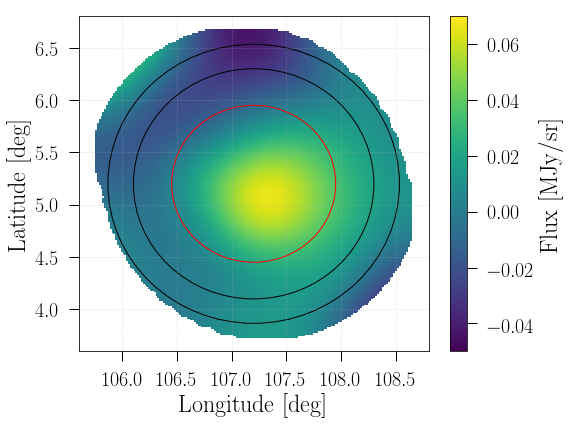

In [57]:
figure()
pc = pcolormesh(rabins, decbins, signal*1.e-6, rasterized=True)
clim(-0.05, 0.07)
cb = colorbar()
cb.set_label('$\mathrm{Flux\ [MJy / sr]}$')

circ1 = Circle((rc, dc), (45./60), facecolor='None', lw=1, edgecolor='r')
circ2 = Circle((rc, dc), (66./60), facecolor='None', lw=1, edgecolor='k')
circ3 = Circle((rc, dc), (80./60), facecolor='None', lw=1, edgecolor='k')
pc.axes.add_patch(circ1)
pc.axes.add_patch(circ2)
pc.axes.add_patch(circ3)

xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xlim(105.6, 108.8)
ylim(3.6, 6.8)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
#savefig('../notebooks/gbt_aperture_smth40.pdf', format='pdf', dpi=300)

In [56]:
80.**2 - 66.12**2

2028.1455999999998

In [52]:
45.**2

2025.0

In [19]:
# CGPS

In [20]:
z = np.load('../externaldata/cgps.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']
sigma1 = np.sqrt(40.**2 - 3.2**2) / 0.7471 / (2. * np.sqrt(2. * np.log(2)))
sigma2 = np.sqrt(40.**2 - 2.8**2)  / 0.9961 / (2. * np.sqrt(2. * np.log(2)))
dsig = gaussian_filter(dsig, [sigma1, sigma2])

In [21]:
nu = 408.e6
dataMJysr = dsig * 2. * kboltz * (nu / clight)**2 * 1.e20

In [22]:
lonc = 107.2
latc = 5.2
lonsq = (dlons - lonc)**2
latsq = (dlats - latc)**2
biglon = np.ones((256, 256)) * lonsq
biglat = np.transpose(np.ones((256, 256)) * latsq)
radius = np.sqrt(biglon + biglat).flatten()
annulus = (radius > (60./60.)) * (radius < (90./60.))
dataflat = dataMJysr.flatten()
adata = dataflat[annulus]
rmask = radius <= 1.
rdata = dataflat[rmask]

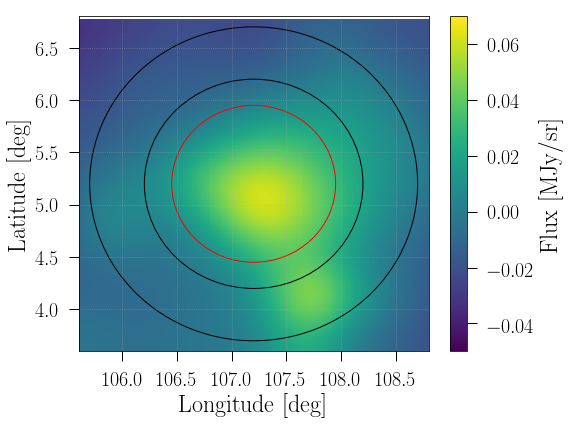

In [23]:
pc = pcolormesh(dlons, dlats, dataMJysr - np.median(adata), rasterized=True)
clim(-0.05, 0.07)
cm = colorbar();
cm.set_label('$\mathrm{Flux\ [MJy / sr]}$')

circ1 = Circle((rc, dc), (45./60), facecolor='None', lw=1, edgecolor='r')
circ2 = Circle((rc, dc), (60./60), facecolor='None', lw=1, edgecolor='k')
circ3 = Circle((rc, dc), (90./60), facecolor='None', lw=1, edgecolor='k')
pc.axes.add_patch(circ1)
pc.axes.add_patch(circ2)
pc.axes.add_patch(circ3)

xlim(lonra)
ylim(latra)
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xlim(105.6, 108.8)
ylim(3.6, 6.8)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
#savefig('../notebooks/cgps_aperture_smoothed40.pdf', format='pdf', dpi=300)

In [22]:
# 1.4 GHz data

In [53]:
stockert = hp.read_map('../externaldata/STOCKERT+VILLA-ELISA_1420MHz_1_256.fits', verbose=False) * 1.e-3
newbeam = np.sqrt(40.**2 - 36.**2)/60.
stockert = hp.smoothing(stockert, fwhm=newbeam*d2r)

Sigma is 7.404216 arcmin (0.002154 rad) 
-> fwhm is 17.435596 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [54]:
nside = hp.get_nside(stockert)
vecc = hp.rotator.dir2vec(lonc, latc, lonlat=True)
rmask = hp.query_disc(nside, vecc, 1.*d2r)
amaskout = set(hp.query_disc(nside, vecc, (90./60.)*d2r))
amaskin = set(hp.query_disc(nside, vecc, (60./60.)*d2r))
amask = np.array(list(amaskout.difference(amaskin)))

In [55]:
nu = 1420.e6
kthermo_to_intensity = 2. * kboltz * (nu / clight)**2 * 1.e20 * 1.55

In [56]:
xdata = stockert * kthermo_to_intensity
xdata -= np.median(xdata[amask])

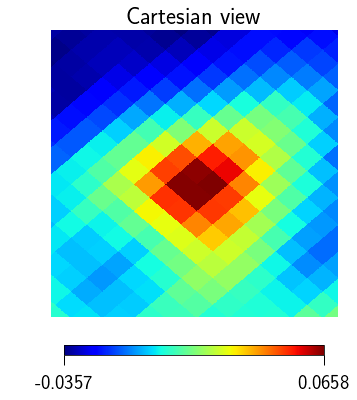

In [57]:
x = hp.cartview(xdata, lonra=lonra, latra=latra, return_projected_map=True, flip='geo')
fig = gcf()
ax = fig.axes[0]
img = ax.images[0]
X = np.linspace(img.get_extent()[0], img.get_extent()[1], 800)
Y = np.linspace(img.get_extent()[2], img.get_extent()[3], 800)

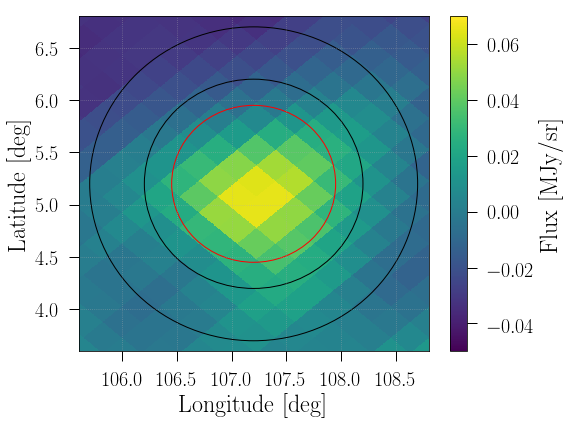

In [59]:
pc = pcolormesh(X, Y, x.data, rasterized=True)
clim(-0.05, 0.07)
cm = colorbar();
cm.set_label('$\mathrm{Flux\ [MJy / sr]}$')

circ1 = Circle((rc, dc), (45./60), facecolor='None', lw=1, edgecolor='r')
circ2 = Circle((rc, dc), (60./60), facecolor='None', lw=1, edgecolor='k')
circ3 = Circle((rc, dc), (90./60), facecolor='None', lw=1, edgecolor='k')
pc.axes.add_patch(circ1)
pc.axes.add_patch(circ2)
pc.axes.add_patch(circ3)

xlim(lonra)
ylim(latra)
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xlim(105.6, 108.8)
ylim(3.6, 6.8)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
savefig('../notebooks/stockert_aperture_smoothed40.pdf', format='pdf', dpi=300)

In [25]:
planckfiles = ['../externaldata/LFI_SkyMap_030-field-IQU_1024_R2.01_full.fits', 
              '../externaldata/LFI_SkyMap_044-field-IQU_1024_R2.01_full.fits',
              '../externaldata/LFI_SkyMap_070-field-IQU_1024_R2.01_full.fits',
              '../externaldata/HFI_SkyMap_100-field-IQU_2048_R2.02_full.fits',
              '../externaldata/HFI_SkyMap_143-field-IQU_2048_R2.02_full.fits',
              '../externaldata/HFI_SkyMap_217-field-IQU_2048_R2.02_full.fits',
              '../externaldata/HFI_SkyMap_353-field-IQU_2048_R2.02_full.fits',
              '../externaldata/HFI_SkyMap_545-field-Int_2048_R2.02_full.fits',
              '../externaldata/HFI_SkyMap_857-field-Int_2048_R2.02_full.fits',]
planckfreqs = np.array([28.4, 44.1, 70.4, 100, 143., 217., 353., 545., 857.]) * 1e9
planckbeams = np.array([32.3, 27.1, 13.3, 7.3, 5., 4.8, 4.7, 4.3])

NSIDE = 1024
ORDERING = NESTED in fits file
Ordering converted to RING
Sigma is 10.019748 arcmin (0.002915 rad) 
-> fwhm is 23.594703 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
28


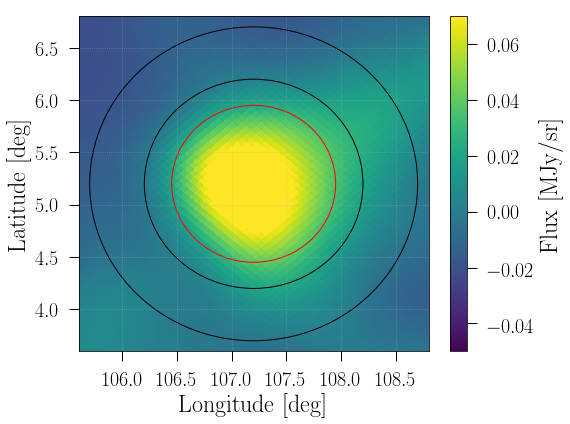

In [41]:
k = 0
fmap = planckfiles[k]
nu = planckfreqs[k]
nuname = str(int(nu*1e-9))
planckmap = hp.read_map(fmap)

newbeam = np.sqrt(40.**2 - planckbeams[k]**2)/60.
planckmap = hp.smoothing(planckmap, fwhm=newbeam*d2r)

nside = hp.get_nside(planckmap)
vecc = hp.rotator.dir2vec(lonc, latc, lonlat=True)
rmask = hp.query_disc(nside, vecc, (45./60.)*d2r)
amaskout = set(hp.query_disc(nside, vecc, (90./60.)*d2r))
amaskin = set(hp.query_disc(nside, vecc, (60./60.)*d2r))
amask = np.array(list(amaskout.difference(amaskin)))
X = hplanck * nu / (kboltz * TCMB)
kthermo_to_intensity = 2. * kboltz * (nu / clight)**2 * (X**2 * np.exp(X)) / (np.exp(X) - 1.)**2
if nu < 400e9:
    xdata = planckmap * kthermo_to_intensity * 1.e20
else:
    xdata = planckmap * 1.
xdata -= np.median(xdata[amask])
figure()
x = hp.cartview(xdata, lonra=lonra, latra=latra, return_projected_map=True, flip='geo')
fig = gcf()
ax = fig.axes[0]
img = ax.images[0]
X = np.linspace(img.get_extent()[0], img.get_extent()[1], 800)
Y = np.linspace(img.get_extent()[2], img.get_extent()[3], 800)
close()
figure()
pc = pcolormesh(X, Y, x.data, rasterized=True)
clim(-0.05, 0.07)
cm = colorbar();
cm.set_label('$\mathrm{Flux\ [MJy / sr]}$')

circ1 = Circle((rc, dc), (45./60), facecolor='None', lw=1, edgecolor='r')
circ2 = Circle((rc, dc), (60./60), facecolor='None', lw=1, edgecolor='k')
circ3 = Circle((rc, dc), (90./60), facecolor='None', lw=1, edgecolor='k')
pc.axes.add_patch(circ1)
pc.axes.add_patch(circ2)
pc.axes.add_patch(circ3)

xlim(lonra)
ylim(latra)
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xlim(105.6, 108.8)
ylim(3.6, 6.8)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
print nuname
#savefig('../notebooks/planck_aperture_'+nuname+'_smoothed40.pdf', format='pdf', dpi=300)

In [43]:
0.53 / 30. * 100.

1.7666666666666668

In [36]:
k = 0
nu = planckfreqs[k]
nuname = str(int(nu*1e-9))
newbeam = np.sqrt(40.**2 - planckbeams[k]**2)/60.

xmap = '/home/mabitbol/GBT-S140/externaldata/LFI_SkyMap_030-field-IQU_1024_R2.01_full.fits'
I, Q, U = hp.read_map(xmap, field=(0, 1, 2))
P = np.sqrt(Q*Q + U*U)

planckmap = hp.smoothing(P, fwhm=newbeam*d2r)

nside = hp.get_nside(planckmap)
vecc = hp.rotator.dir2vec(lonc, latc, lonlat=True)
rmask = hp.query_disc(nside, vecc, (45./60.)*d2r)
amaskout = set(hp.query_disc(nside, vecc, (90./60.)*d2r))
amaskin = set(hp.query_disc(nside, vecc, (60./60.)*d2r))
amask = np.array(list(amaskout.difference(amaskin)))
X = hplanck * nu / (kboltz * TCMB)
kthermo_to_intensity = 2. * kboltz * (nu / clight)**2 * (X**2 * np.exp(X)) / (np.exp(X) - 1.)**2
if nu < 400e9:
    xdata = planckmap * kthermo_to_intensity * 1.e20
else:
    xdata = planckmap * 1.
xdata -= np.median(xdata[amask])
figure()
x = hp.cartview(xdata, lonra=lonra, latra=latra, return_projected_map=True, flip='geo')
fig = gcf()
ax = fig.axes[0]
img = ax.images[0]
X = np.linspace(img.get_extent()[0], img.get_extent()[1], 800)
Y = np.linspace(img.get_extent()[2], img.get_extent()[3], 800)
close()

NSIDE = 1024
ORDERING = NESTED in fits file
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Sigma is 10.019748 arcmin (0.002915 rad) 
-> fwhm is 23.594703 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.530882760391


28


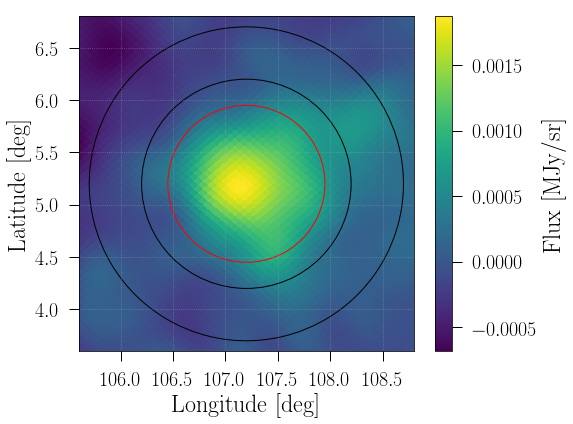

In [37]:
figure()
pc = pcolormesh(X, Y, x.data, rasterized=True)
#clim(-0.0005, 0.0015)
cm = colorbar();
cm.set_label('$\mathrm{Flux\ [MJy / sr]}$')

circ1 = Circle((rc, dc), (45./60), facecolor='None', lw=1, edgecolor='r')
circ2 = Circle((rc, dc), (60./60), facecolor='None', lw=1, edgecolor='k')
circ3 = Circle((rc, dc), (90./60), facecolor='None', lw=1, edgecolor='k')
pc.axes.add_patch(circ1)
pc.axes.add_patch(circ2)
pc.axes.add_patch(circ3)

xlim(lonra)
ylim(latra)
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xlim(105.6, 108.8)
ylim(3.6, 6.8)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
print nuname
#savefig('../notebooks/planck_polarization_aperture_'+nuname+'_smoothed40.pdf', format='pdf', dpi=300)

In [35]:
np.max(x.data) / 0.1 * 100

1.876239897098416

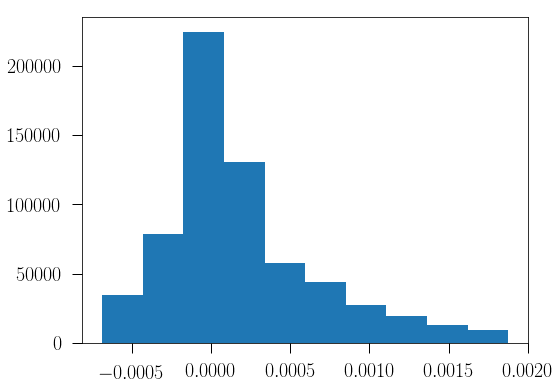

In [32]:
hist(x.data.flatten());

In [ ]:
lonc = 107.2
latc = 5.2

In [ ]:
irisfiles = ['../externaldata/IRIS_nohole_1_2048.fits', \
            '../externaldata/IRIS_nohole_2_2048.fits', \
            '../externaldata/IRIS_nohole_3_2048.fits', \
            '../externaldata/IRIS_nohole_4_2048.fits']
irisfreqs = np.array([25000, 12000, 5000, 3000]) * 1.e9
irisbeams = np.array([3.8, 3.8, 4.0, 4.3])

In [ ]:
k = 3
imap = irisfiles[k]
ifreq = irisfreqs[k]
nuname = str(int(ifreq*1e-9))
irismap = hp.read_map(imap, verbose=False)
mask = irismap == -32768
irismap[mask] = hp.UNSEEN
mask = np.isnan(irismap)
irismap[mask] = hp.UNSEEN
nside = hp.get_nside(irismap)

vecc = hp.rotator.dir2vec(lonc, latc, lonlat=True)
rmask = hp.query_disc(nside, vecc, 1.*d2r)
amaskout = set(hp.query_disc(nside, vecc, (90./60.)*d2r))
amaskin = set(hp.query_disc(nside, vecc, (60./60.)*d2r))
amask = np.array(list(amaskout.difference(amaskin)))

irismap -= np.nanmedian(irismap[amask])

figure()
x = hp.cartview(irismap, lonra=lonra, latra=latra, return_projected_map=True, flip='geo')
fig = gcf()
ax = fig.axes[0]
img = ax.images[0]
X = np.linspace(img.get_extent()[0], img.get_extent()[1], 800)
Y = np.linspace(img.get_extent()[2], img.get_extent()[3], 815)
close()
figure()
pcolormesh(X, Y, x.data, rasterized=True)

clim(-2, 300)

cm = colorbar();
contour(gridx, gridy, signal*1.e-6, levels=np.linspace(-0.12, 0.12, 12), cmap=matplotlib.cm.YlOrRd)
cm.set_label('$\mathrm{Flux\ [MJy / sr]}$')
xlim(lonra)
ylim(latra)
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
savefig('../notebooks/iris'+nuname+'_contours.pdf', format='pdf', dpi=300)